# Quant GAN
## Tensor Flow Version
[Wiese et al., Quant GANs: Deep Generation of Financial Time Series, 2019](https://arxiv.org/abs/1907.06673)

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from preprocess.acf import *
from preprocess.gaussianize import *

from tensorflow.random import normal
from tensorflow.keras.models import load_model
import yfinance as yf
from model.tf_gan import GAN
from model.tf_tcn import *

[*********************100%***********************]  1 of 1 completed


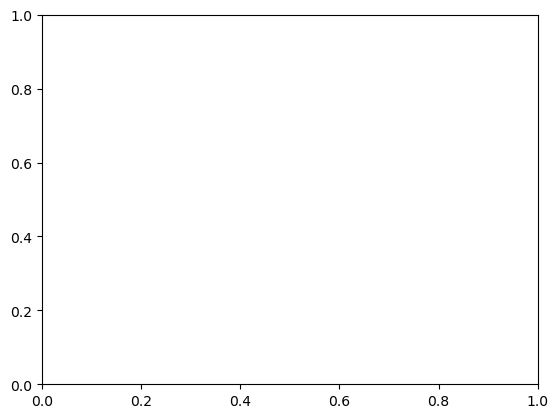

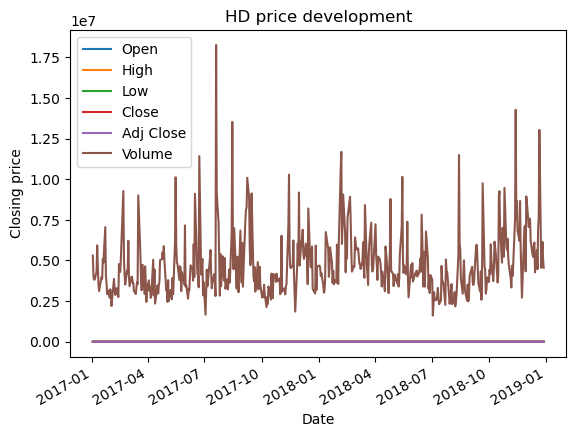

In [231]:
ticker = "HD"#"^GSPC"
df = yf.download(ticker, start="2017-01-01", end="2018-12-31")
ts = df['Adj Close']

fig, ax = plt.subplots()
df.plot(ylabel='Closing price', title=ticker + ' price development');

## Preprocess data
 For more details see [preprocess.ipynb](./preprocess.ipynb)

In [232]:
file_name = 'AAPL_daily' 
generator_path = f'/trained/'
receptive_field_size = 127
fixed_filters = 80
block_size = 2

standardScaler1 = StandardScaler()
standardScaler2 = StandardScaler()
gaussianize = Gaussianize()

log_returns = np.log(ts/ts.shift(1))[1:].to_numpy().reshape(-1, 1)
log_returns_preprocessed = standardScaler2.fit_transform(gaussianize.fit_transform(standardScaler1.fit_transform(log_returns)))
print(log_returns.shape[0])

500


## Train model
 For more details see [tf_model.ipynb](./tf_model.ipynb)

In [233]:
#generator = TCN([None, 3])
generator = load_model(f"/Users/andreypak/Downloads/temporalCN-main/trained/trained_generator_SP500_daily")

discriminator = TCN([receptive_field_size, 1],fixed_filters = 100)

input_dim: [1, 127, 1]
kernel_size: 1  dilation: 1, fixed_filters: 100 cropping: 0
kernel_size: 2  dilation: 1, fixed_filters: 100 cropping: 0
kernel_size: 2  dilation: 2, fixed_filters: 100 cropping: 2
kernel_size: 2  dilation: 4, fixed_filters: 100 cropping: 6
kernel_size: 2  dilation: 8, fixed_filters: 100 cropping: 14
kernel_size: 2  dilation: 16, fixed_filters: 100 cropping: 30
kernel_size: 2  dilation: 32, fixed_filters: 100 cropping: 62


In [234]:
train = True

if train:
  gan = GAN(discriminator, generator, 2 * receptive_field_size - 1, lr_d=1e-4, lr_g=3e-5)
  gan.acf_real = acf(log_returns_preprocessed, 250)
  gan.abs_acf_real = acf(log_returns_preprocessed**2, 250)
  gan.le_real = acf(log_returns_preprocessed, 250, le=True)
  gan.fixed_noise = normal([128, 1, 200 + receptive_field_size - 1, 3])
  log_returns_rolled = rolling_window(log_returns_preprocessed, receptive_field_size)
  data = np.expand_dims(np.moveaxis(log_returns_rolled, 0,1), 1).astype('float32')
  batch_size = 64
  n_batches = 20
  gan.train(data, batch_size, n_batches)
  #generator.save(f"{generator_path}trained_generator_{file_name}")
else:
  print(f"Loading: {generator_path}trained_generator_{file_name}")
  generator = load_model(f"{generator_path}trained_generator_{file_name}")
  # generator = load_model(f"/temporalCN/trained/trained_generator_ShanghaiSE_daily")


20/20 [==============================] - 26s 482ms/step


## Generate

In [127]:
#noise = normal([512, 1, len(log_returns_preprocessed) + receptive_field_size - 1, 3])
noise = normal([1000, 1, 500, 3])

y = generator(noise).numpy().squeeze()


y = (y - y.mean(axis=0))/y.std(axis=0)
y = standardScaler2.inverse_transform(y)
y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = standardScaler1.inverse_transform(y)

# some basic filtering to reduce the tendency of GAN to produce extreme returns
y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]
y -= y.mean()
len(y)

968

## Results and visualizing stylized facts

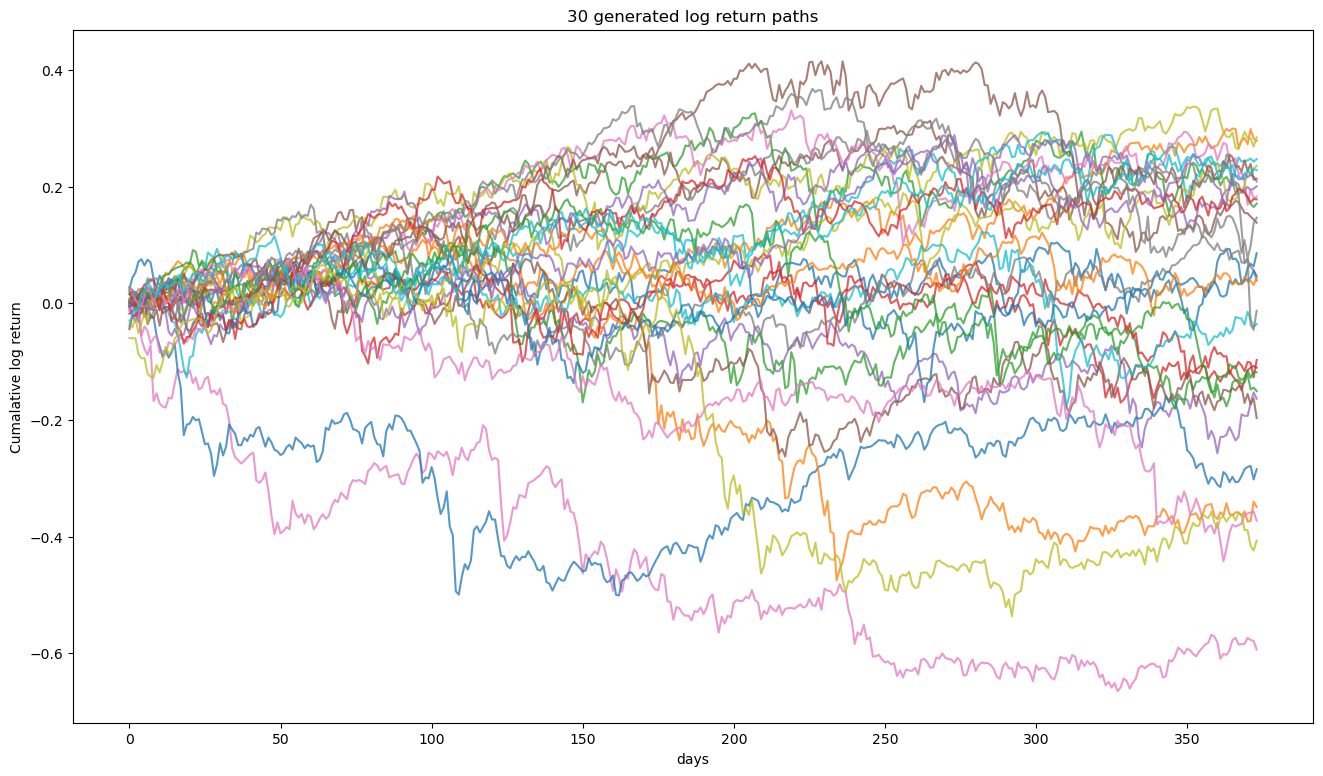

In [128]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y[0:30], axis=1).T, alpha=0.75)
ax.set_title('30 generated log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return');

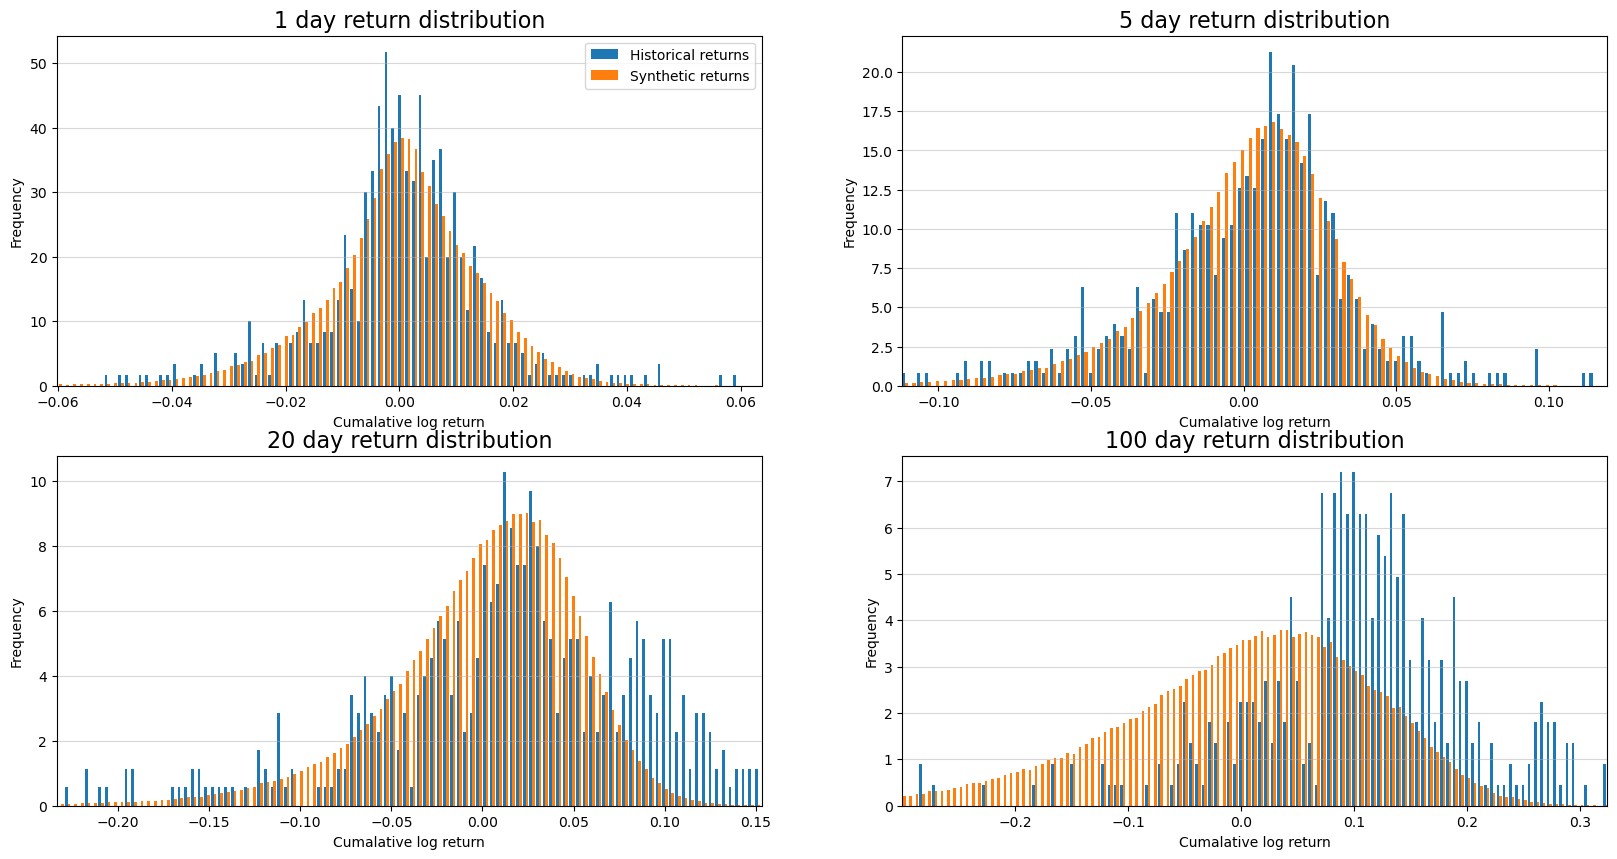

In [129]:
n_bins = 200
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))


for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=n_bins, density=True)
    axs[row,col].set_xlim(*np.quantile(real_dist, [0.001, .999]))
    
    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumalative log return')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical returns', 'Synthetic returns'])


[Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days')]

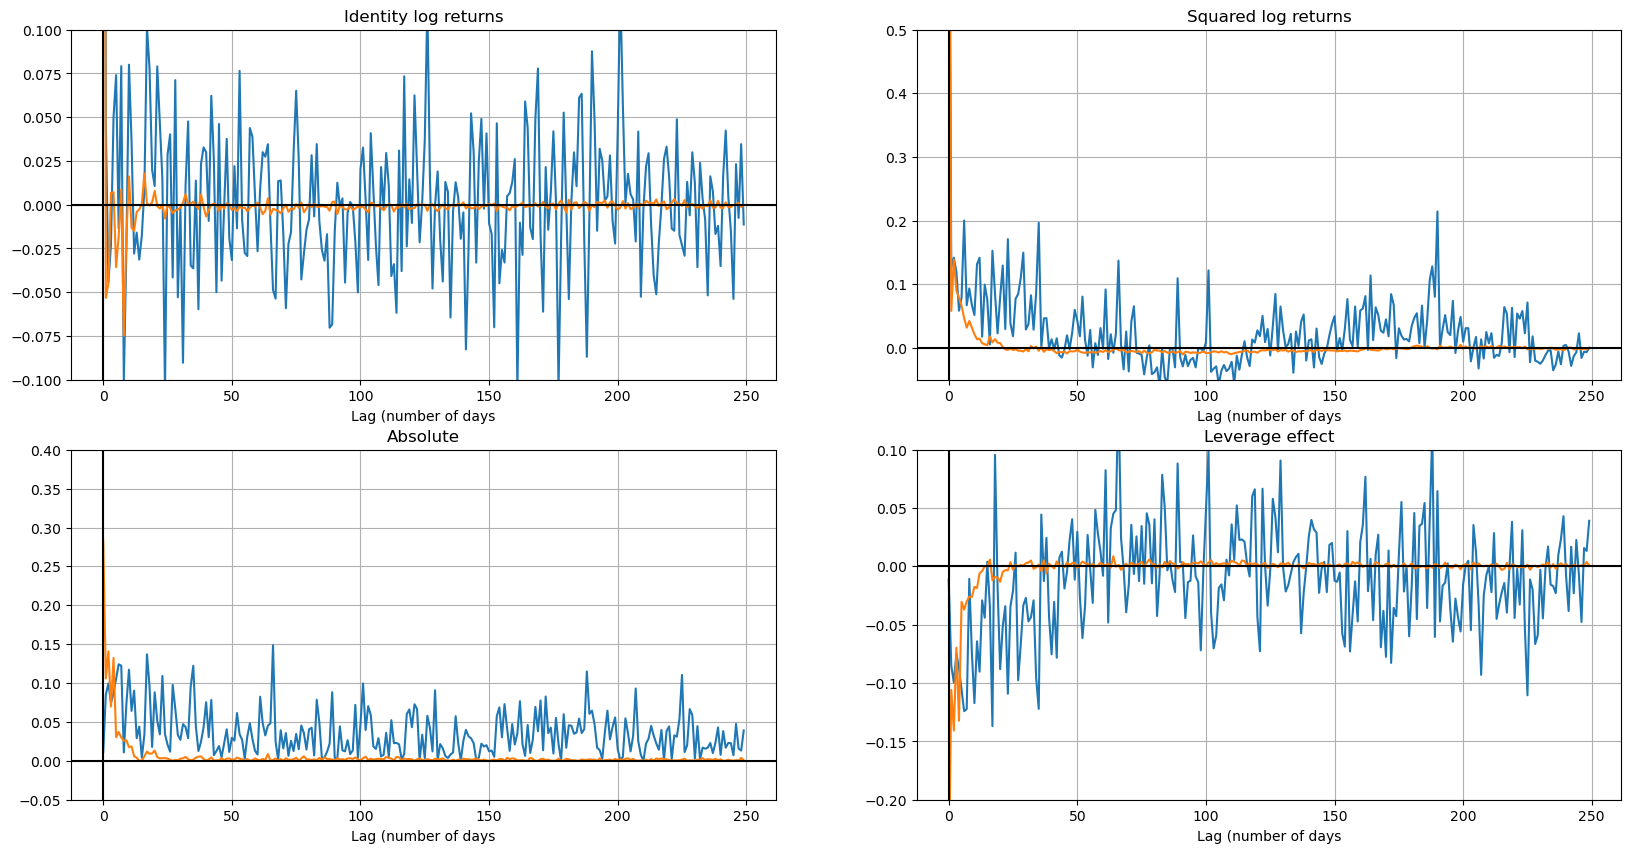

In [130]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

axs[0,0].plot(acf(log_returns, 250))
axs[0,0].plot(acf(y.T, 250).mean(axis=1))
axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('Identity log returns')
axs[0,1].plot(acf(log_returns**2, 250))
axs[0,1].set_ylim(-0.05, 0.5)
axs[0,1].plot(acf(y.T**2, 250).mean(axis=1))
axs[0,1].set_title('Squared log returns')
axs[1,0].plot(abs(acf(log_returns, 250, le=True)))
axs[1,0].plot(abs(acf(y.T, 250, le=True).mean(axis=1)))
axs[1,0].set_ylim(-0.05, 0.4)
axs[1,0].set_title('Absolute')
axs[1,1].plot(acf(log_returns, 250, le=True))
axs[1,1].plot(acf(y.T, 250, le=True).mean(axis=1))
axs[1,1].set_ylim(-0.2, 0.1)
axs[1,1].set_title('Leverage effect')


for ax in axs.flat: 
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
plt.setp(axs, xlabel='Lag (number of days')

The purchase price of stock is 154.68299865722656.
The selling price of stock in 174 is [].
There is 0.05 probability that the stock price will fall below 117.91955718994141 over a 174-day period.


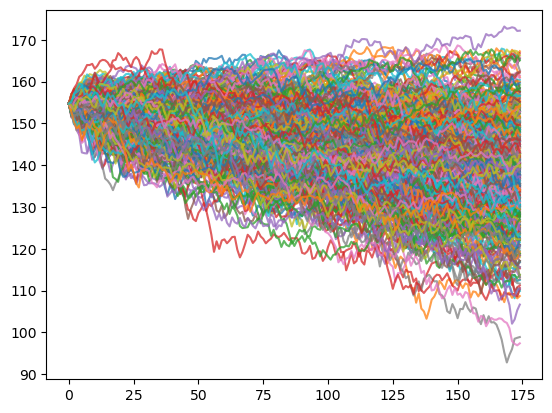

In [246]:
from datetime import datetime

DateOfPurchase = datetime.strptime("2018-12-28",'%Y-%m-%d')
DateOfSell = datetime.strptime("2019-06-20",'%Y-%m-%d')
NSim = 500

NDays = (DateOfSell - DateOfPurchase).days
S0 = df.loc[df.index == DateOfPurchase.strftime('%Y-%m-%d')]["Adj Close"].to_numpy().squeeze()
print(f"The purchase price of stock is {S0}.")
S1 = df.loc[df.index == DateOfSell.strftime('%Y-%m-%d')]["Adj Close"].to_numpy().squeeze()
print(f"The selling price of stock in {NDays} is {S1}.")

noise = normal([NSim, 1, NDays+receptive_field_size-1, 3])
y = generator(noise).numpy().squeeze()
S = np.cumsum(np.insert(y, 0, np.ones(NSim)*S0, axis=1), axis=1)

print(f"There is 0.05 probability that the stock price will fall below {np.quantile(S[:,-1], 0.05)} over a {NDays}-day period.")
plt.plot(S.T, alpha=0.75)


In [239]:
S = np.cumsum(np.insert(y, 0, np.ones(500)*S0, axis=1), axis=1)

119.55166625976562


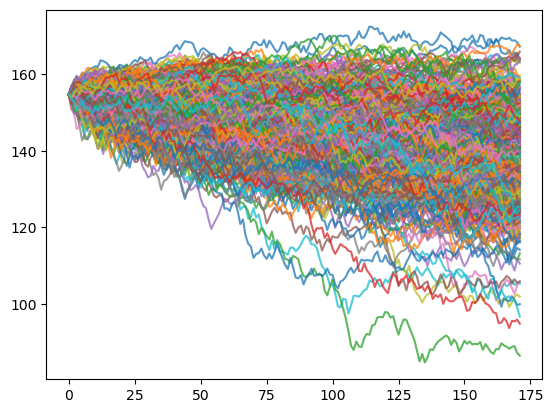